In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = BlockRNNModel(
        model="GRU",
        model_name=f"model_{fold+1}",
        input_chunk_length=24,
        hidden_dim=188,
        n_rnn_layers=1,
        n_epochs=100,
        batch_size=172,
        dropout=0.463770421977072,
        add_encoders=encoders,
        output_chunk_length=1,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.SmoothL1Loss(),
        optimizer_cls=torch.optim.AdamW,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0020101615632169517, "weight_decay": 4.080126913056516e-06},
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.040
Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.030
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.021
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.001 >= min_del

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE        R2  \
Temperature                    4.752625    2.180052    1.697513  0.905099   
Precipitation_accumulated      0.174952    0.418273    0.294117  0.721459   
Humidity                      28.955552    5.381036    3.967055  0.907583   
Wind_Speed_kmh                 0.288383    0.537013    0.411398  0.317290   
Soil_Moisture              37358.852127  193.284381  121.140288  0.939554   
Soil_Temperature               9.152837    3.025366    2.339787  0.873888   
Wind_Dir_Sin                   0.254916    0.504892    0.392355  0.201527   
Wind_Dir_Cos                   0.314540    0.560839    0.421715  0.184846   

                               SMAPE  
Temperature                10.916335  
Precipitation_accumulated   9.083919  
Humidity                    6.513420  
Wind_Speed_kmh             51.315910  
Soil_Moisture        

Metric val_loss improved. New best score: 6.222
Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 6.186
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.184
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.178
Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 6.167
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.161
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.159
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.156
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.148
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.145
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.137
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.136
Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 6.128
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE          R2  \
Temperature                7.992424e+01     8.940036     7.266702   -1.298805   
Precipitation_accumulated  1.335065e+05   365.385358   311.490070   -2.343205   
Humidity                   4.801465e+02    21.912246    18.438468   -2.814734   
Wind_Speed_kmh             6.284671e+01     7.927592     6.853446 -190.368188   
Soil_Moisture              7.704218e+06  2775.647386  2371.351451   -4.116807   
Soil_Temperature           3.134313e+01     5.598494     4.563495    0.125786   
Wind_Dir_Sin               3.707535e+00     1.925496     1.706030  -14.527084   
Wind_Dir_Cos               4.505036e-01     0.671196     0.591663    0.310421   

                                SMAPE  
Temperature                 53.471422  
Precipitation_accumulated  134.840031  
Humidity                    19.915460  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    1.866238    1.366103    1.091031  6.675618e-01   
Precipitation_accumulated    391.324256   19.781917   18.645452 -3.270694e+06   
Humidity                       7.465043    2.732223    2.216044  5.648532e-01   
Wind_Speed_kmh                 0.006279    0.079241    0.063408          -inf   
Soil_Moisture              49337.465516  222.120385  192.864466 -3.601227e+01   
Soil_Temperature               3.213707    1.792681    1.522270  4.946519e-01   
Wind_Dir_Sin                   0.019019    0.137909    0.124255          -inf   
Wind_Dir_Cos                   0.008025    0.089582    0.074510          -inf   

                                SMAPE  
Temperature                  7.523339  
Precipitation_accumulated    3.978792  
Humidity                     2.546081  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.002
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    0.363596    0.602989    0.444561     0.360243   
Precipitation_accumulated     70.598734    8.402305    7.733632 -2138.652954   
Humidity                       6.095052    2.468816    2.035408     0.372354   
Wind_Speed_kmh                 0.079839    0.282558    0.265523         -inf   
Soil_Moisture              29501.097236  171.758835  152.034351     0.159725   
Soil_Temperature               0.520785    0.721654    0.542822    -1.268143   
Wind_Dir_Sin                   0.004069    0.063789    0.051804         -inf   
Wind_Dir_Cos                   0.004771    0.069073    0.054884         -inf   

                                SMAPE  
Temperature                  4.795408  
Precipitation_accumulated    1.704103  
Humidity                     2.251149  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.004
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   3.126158   1.768094   1.524963   -0.314951   
Precipitation_accumulated    78.111800   8.838088   6.010171 -274.706018   
Humidity                     45.646574   6.756225   5.845226    0.026224   
Wind_Speed_kmh                0.020984   0.144860   0.115685   -9.140812   
Soil_Moisture              6964.825038  83.455527  70.874506    0.130337   
Soil_Temperature              0.657974   0.811156   0.628770    0.594525   
Wind_Dir_Sin                  0.012070   0.109865   0.046799    0.790381   
Wind_Dir_Cos                  0.017542   0.132444   0.063183    0.800677   

                                SMAPE  
Temperature                 20.544753  
Precipitation_accumulated    1.326818  
Humidity                     6.901800  
Wind_Speed_kmh             189.039071  
Soil_Moisture            

Metric val_loss improved. New best score: 0.027
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.018
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.011
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.011. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layer

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE           R2  \
Temperature                     1.589965    1.260938    0.919303     0.829801   
Precipitation_accumulated    1299.678794   36.051058   31.391170 -1119.142681   
Humidity                       34.299422    5.856571    4.877266     0.703034   
Wind_Speed_kmh                  0.687873    0.829381    0.582060     0.557728   
Soil_Moisture              300998.424605  548.633233  474.188263     0.767640   
Soil_Temperature                2.172348    1.473889    1.062094     0.567942   
Wind_Dir_Sin                    0.322684    0.568053    0.415619     0.325901   
Wind_Dir_Cos                    0.291935    0.540310    0.402660     0.398853   

                                SMAPE  
Temperature                 31.675543  
Precipitation_accumulated    7.112238  
Humidity                     5.355984  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.024
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: Poss

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.213357   1.487735   1.203432    0.918177   
Precipitation_accumulated   193.627769  13.915020  12.319206 -631.750005   
Humidity                     22.081245   4.699068   3.622776    0.854177   
Wind_Speed_kmh                0.482126   0.694353   0.519968    0.598455   
Soil_Moisture              9361.134730  96.752957  83.371377   -0.578541   
Soil_Temperature              1.006718   1.003353   0.784934    0.909912   
Wind_Dir_Sin                  0.384991   0.620477   0.504528    0.283097   
Wind_Dir_Cos                  0.295953   0.544016   0.440467    0.128185   

                                SMAPE  
Temperature                 13.585720  
Precipitation_accumulated    2.689919  
Humidity                     4.458025  
Wind_Speed_kmh              52.136121  
Soil_Moisture            

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.463770421977072 and num_layers=1


BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=188, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.463770421977072, activation=ReLU, model_name=model_1, input_chunk_length=24, n_epochs=100, batch_size=172, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, output_chunk_length=1, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fa1189a21b0>]}, loss_fn=SmoothL1Loss(), optimizer_cls=<class 'torch.optim.adamw.AdamW'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42, optimizer_kwargs={'lr': 0.0020101615632169517, 'weight_decay': 4.080126913056516e-

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


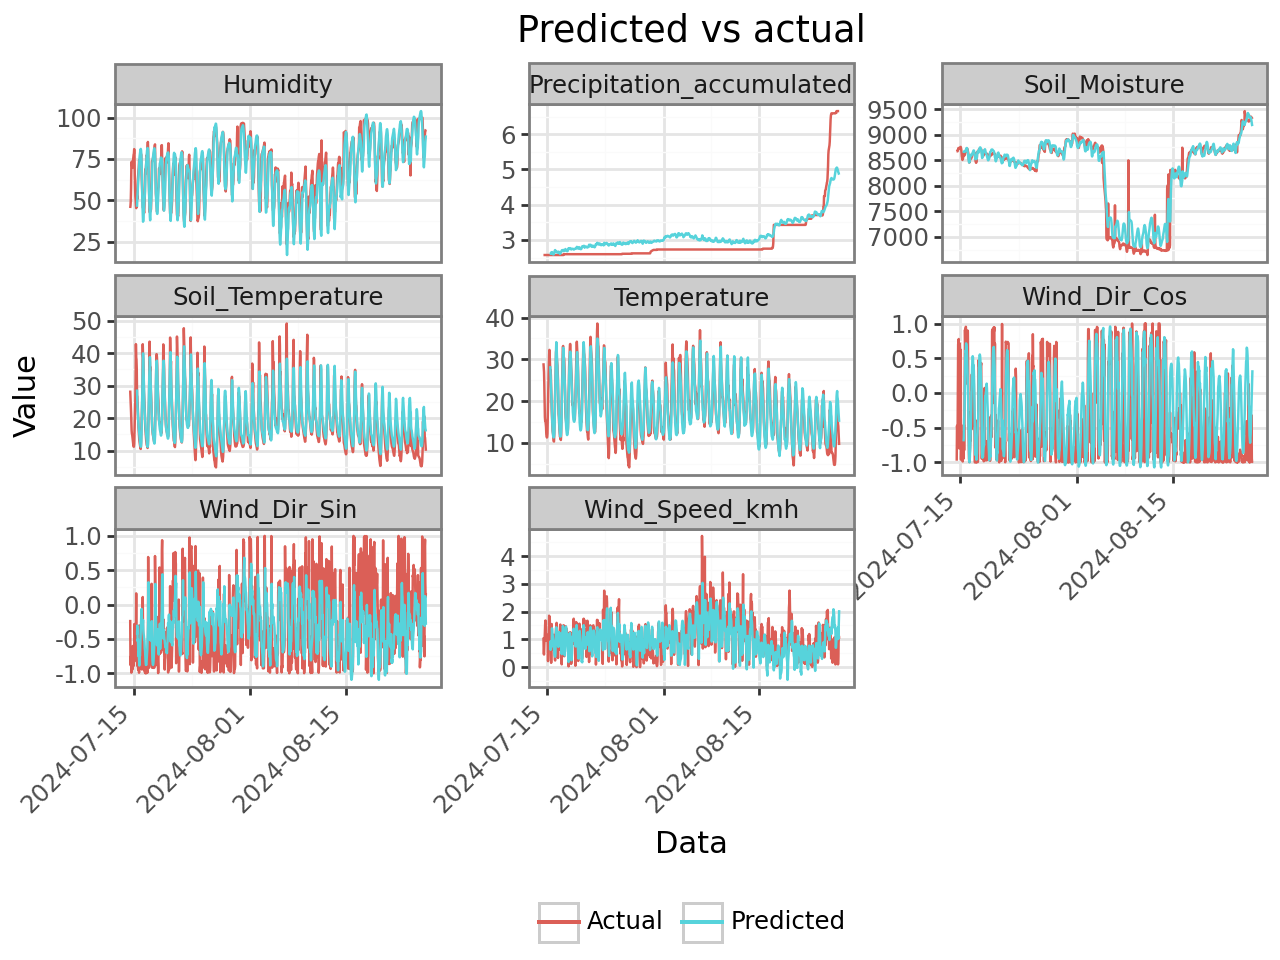

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

In [8]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

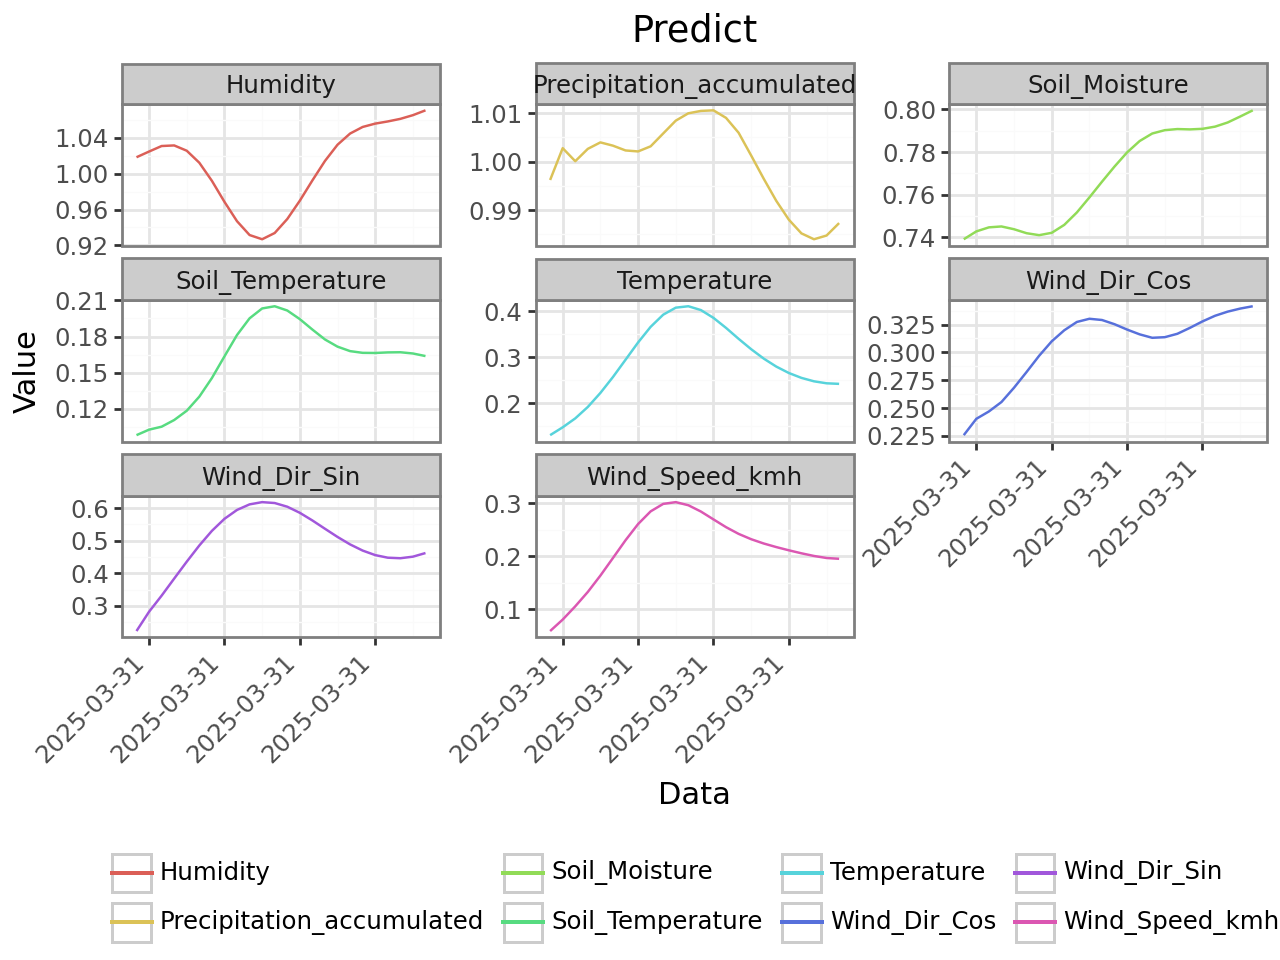

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_24_horas.png


In [9]:
plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
    ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y') # Cria um subplot para cada 'target_column'
    + labs(
        title='Predict',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
        
    )
)
plot.show()
plot.save('predict_24.png', width=12, height=10, dpi=300)

In [10]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)